# Checks if Perfsonar data is indexed

This notebook checks number of indexed documents in all perfsonar indices and alerts if any of them is significantly less then usual. It sends mails to all the people substribed to that alert. It is run every 30 min from a cron job.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', **{'size': 12})

import pandas as pd

from subscribers import subscribers
import alerts

from datetime import datetime, timedelta
from elasticsearch import Elasticsearch, exceptions as es_exceptions
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

### define what are the indices to look for
first number is interval to check (in hours), second is number in 2 previous intervals, third is number in current interval.

In [2]:
ps_indices={
    'ps_meta':[24, 0, 0],
    'ps_owd':[1, 0, 0],
    'ps_packet_loss':[1, 0, 0],
    'ps_retransmits':[1, 0, 0],
    'ps_status':[1, 0, 0],
    'ps_throughput':[1, 0, 0],
    'ps_trace':[1, 0, 0]
}

In [3]:
# There is a time offset here - we do now-9 instead of expected now-1. 
# two reasons: 1. we get data with a delay 2. there is an issue with timezones even data is indexed in UTC.

sub_end = (datetime.utcnow()- timedelta(hours=9)).replace(microsecond=0,second=0,minute=0)
print('end of subject period: ',sub_end)
    
for ind in ps_indices:
    print ("Checking: ", ind)
    tbin=ps_indices[ind][0]

    ref_start = sub_end - timedelta(hours=tbin*3)
    ref_end = sub_end - timedelta(hours=tbin)
    print('reference interval:', ref_start, ' till ', ref_end)
    
    ref_start = int(ref_start.timestamp()*1000)
    ref_end = int(ref_end.timestamp()*1000)
    
    types_query={
       "size": 0,
       "query": {
            "bool":{
                "filter":{
                    "range":{"timestamp":{"gt": ref_start, 'lte':ref_end}}
                }
            }
       }
    }

    res = es.search(index=ind, body=types_query, request_timeout=120)
    ps_indices[ind][1] = res['hits']['total']
 
    types_query={
       "size": 0,
       "query": {
            "bool":{
                "filter":{
                    "range":{"timestamp":{"gt": ref_end, 'lte':int(sub_end.timestamp()*1000)}}
                }
            }
       }
    }

    res = es.search(index=ind, body=types_query, request_timeout=120)
    ps_indices[ind][2] = res['hits']['total']

end of subject period:  2018-02-23 10:00:00
Checking:  ps_status
reference interval: 2018-02-23 07:00:00  till  2018-02-23 09:00:00
Checking:  ps_packet_loss
reference interval: 2018-02-23 07:00:00  till  2018-02-23 09:00:00
Checking:  ps_meta
reference interval: 2018-02-20 10:00:00  till  2018-02-22 10:00:00
Checking:  ps_owd
reference interval: 2018-02-23 07:00:00  till  2018-02-23 09:00:00
Checking:  ps_trace
reference interval: 2018-02-23 07:00:00  till  2018-02-23 09:00:00
Checking:  ps_throughput
reference interval: 2018-02-23 07:00:00  till  2018-02-23 09:00:00
Checking:  ps_retransmits
reference interval: 2018-02-23 07:00:00  till  2018-02-23 09:00:00


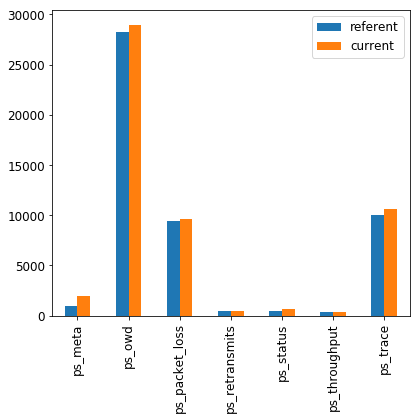

In [4]:
df = pd.DataFrame(ps_indices)
df = df[1:].transpose()
df.columns=["referent","current"]
df.referent= df.referent/2
df.plot(kind="bar")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(6, 6)
plt.tight_layout()
plt.savefig('Images/Check_perfsonar_indexing.png')

In [5]:
df['change'] = df['current']/df['referent']
df['pr1'] = df['current'] < 10
df['pr2'] = df['change'] < 0.7
df['problem']=df['pr1'] | df['pr1']
df.head(10)

,referent,current,change,pr1,pr2,problem
ps_meta,978.5,1966,2.009198,False,False,False
ps_owd,28245.0,28965,1.025491,False,False,False
ps_packet_loss,9417.5,9659,1.025644,False,False,False
ps_retransmits,427.0,494,1.156909,True,False,True
ps_status,429.0,686,1.599068,True,False,True
ps_throughput,319.5,381,1.192488,True,False,True
ps_trace,10059.0,10660,1.059747,False,False,False


In [6]:
problematic=df[df['problem']==True]
print(problematic.head(10))

if problematic.shape[0] > 0:
    S = subscribers()
    A = alerts.alerts()

    test_name = 'Alert on Elastic indexing rate [PerfSonar]'
    users =  S.get_immediate_subscribers(test_name)
    for user in users:
        body = 'Dear ' + user.name+',\n\n'
        body += '\tthis mail is to let you know that there is an issue in indexing Perfsonar data in UC Elasticsearch.\n'
        A.send_HTML_mail(
            'Networking alert',
            user.email,
            body,
            subtitle=test_name,
            images=[
                    {
                    "Title":'Current vs Referent time',
                    "Description":"This plot shows number of documents indexed in two intervals. The Current interval is 1h long except for meta data (24h). Referent interval is just before current interval but is twice longer.",
                    "Filename":"Images/Check_perfsonar_indexing.png",
                    "Link":"http://bit.ly/2BKKO4u"
                    }
                   ]
        )
        
        print(user.to_string())
        A.addAlert(test_name, user.name, 'just an issue.')

                referent  current    change   pr1    pr2  problem
ps_retransmits     427.0      494  1.156909  True  False     True
ps_status          429.0      686  1.599068  True  False     True
ps_throughput      319.5      381  1.192488  True  False     True
user name:Ilija Vukotic  email:ilija@vukotic.me
user name:Ilija Vukotic  email:ilijav@gmail.com
user name:Marian Babik  email:marian.babik@cern.ch
user name:Shawn McKee  email:smckee@umich.edu
